In [7]:
import rishi_utils as ru
from rdkit import Chem
import fall20_mse_8803 as retro
import importlib
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
importlib.reload(retro)
importlib.reload(ru)
import numpy as np
import pickle
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 600

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz
Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz


# Make ring-closing rxn

In [4]:
importlib.reload(ru)

<module 'rishi_utils' from '/home/rgur/py_scripts/rishi_utils.py'>

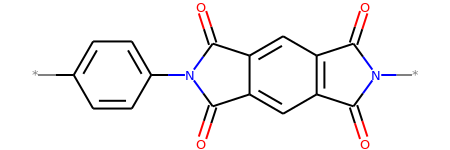

In [5]:
mol = Chem.MolFromSmiles('*c4ccc(n3c(=O)c2cc1c(=O)n(*)c(=O)c1cc2c3=O)cc4')
mol

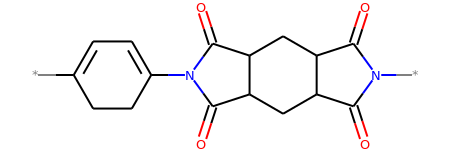

In [6]:
mol2 = Chem.MolFromSmiles('*c4ccc(N3C(=O)C2CC1C(=O)N(*)C(=O)C1CC2C3=O)CC4')
mol2

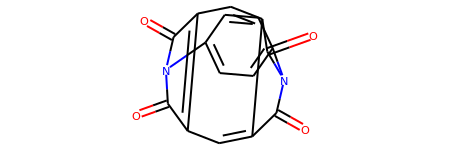

In [7]:
lp = ru.LinearPol(mol)
pm = lp.PeriodicMol()
pm.GetSSSR()
pm.mol

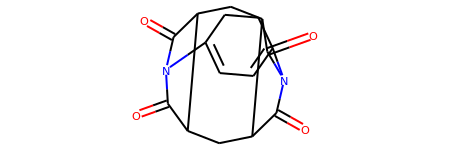

In [8]:
lp2 = ru.LinearPol(mol2)
pm2 = lp2.PeriodicMol()
pm2.GetSSSR()
pm2.mol

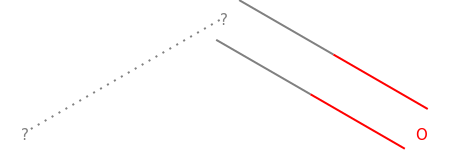

In [9]:
start_match = Chem.MolFromSmarts('[cR,CR](=O)[nR,NR]') #the ring we want to break
start_match

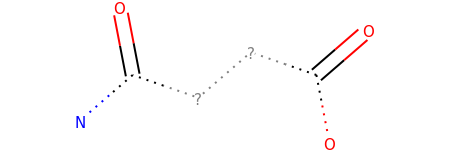

In [10]:
end_match = Chem.MolFromSmarts('[#6R0](=O)([OH])[C,c][C,c][CR1](=O)[NR1]') #the group we want to end up with
end_match

In [11]:
pm.HasSubstructMatch(start_match),pm2.HasSubstructMatch(start_match)  #should be True, True

(True, True)

In [12]:
pm.mol.HasSubstructMatch(end_match),pm2.mol.HasSubstructMatch(end_match)  #should be False, False

(False, False)

In [144]:
import itertools

#works for non-aromatic systems
new_mol = None
new_mol2 = None
med_mol = None
lps = []
lp_no_connect_inds = np.array([x for x in range(lp.mol.GetNumAtoms()) if x not in lp.star_inds])
def lp_to_pm_ind(lp_ind):
    return int(np.argwhere(lp_no_connect_inds==lp_ind))

ri = lp.mol.GetRingInfo()
ar = ri.AtomRings()
ar_atom_idx = [a.GetIdx() for a in lp.mol.GetAromaticAtoms()]
atom_aromaticity = {a:0 for a in ar_atom_idx}

for ring in ar:
    if ring[0] in ar_atom_idx:
        for a in ring:
            atom_aromaticity[a] += 1

if pm.mol.HasSubstructMatch(start_match) and not pm.mol.HasSubstructMatch(end_match): 
    matches = pm.mol.GetSubstructMatches(start_match)
    for L in range(1, len(matches)+1):
    #for L in range(2,3):
        for match_combo in itertools.combinations(matches,L):
            em = Chem.EditableMol(pm.mol)
            print('Match combo:', match_combo)
            for i_c,i_o,i_n in match_combo: #indices of atoms in pm
                
                print('Matches: %s %s %s' %(i_c,i_o,i_n) )
                fix_aromaticity = False
                if pm.mol.GetBondBetweenAtoms(i_c,i_n).GetBondType() == Chem.BondType.AROMATIC:
                    fix_aromaticity = True
                    ring_atoms = None
                    ring_size = 100
                    for i in range(len(ar)):
                        ring = ar[i]
                        if lp_no_connect_inds[i_c] in ring and lp_no_connect_inds[i_n] in ring and len(ring) < ring_size: #assume correct ring is the smallest one
                            ring_atoms = set(ring)
                            ring_size = len(ring)

                o=em.AddAtom(Chem.AtomFromSmiles('O'))
                em.AddBond(i_c,o,Chem.BondType.SINGLE)
                print('bond between %s and %s' %(i_c,o))
                em.RemoveBond(i_c,i_n)
                print('Bond removed between %s and %s' %(i_c,i_n))

                med_mol = em.GetMol()
                if fix_aromaticity:
                    i_n_aromaticity = atom_aromaticity[ lp_to_pm_ind(i_n) ]
                    for i in ring_atoms:
                        if atom_aromaticity[ i ] == i_n_aromaticity: #if an atom was part of same number of aromatic rings as the N atom, it shouldn't be aromatic
                            print('Ring atom lp:',i)
                            pm_i = lp_to_pm_ind(i)
                            print('Ring atom pm:',pm_i)
                            med_mol.GetAtomWithIdx( pm_i ).SetIsAromatic(False)
                            #remove all aromatic bonds
                            neighs = [x.GetIdx() for x in med_mol.GetAtoms()[ pm_i ].GetNeighbors()]
                            aromatic_neighs = [x for x in neighs if med_mol.GetBondBetweenAtoms(pm_i,x).GetBondType()==Chem.BondType.AROMATIC]
                            print('Aromatic neighs of %s: %s' %(pm_i,aromatic_neighs))
                            em = Chem.EditableMol(med_mol)
                            for x in aromatic_neighs:
                                em.RemoveBond( x, pm_i )
                                em.AddBond(x,pm_i, Chem.BondType.SINGLE)
                            med_mol = em.GetMol()     
            
            em = Chem.EditableMol(med_mol)
            star1 = em.AddAtom(Chem.AtomFromSmiles('*'))
            star2 = em.AddAtom(Chem.AtomFromSmiles('*'))
            em.RemoveBond(pm.connector_inds[0],pm.connector_inds[1])
            em.AddBond(pm.connector_inds[0],star1,Chem.BondType.SINGLE)
            em.AddBond(pm.connector_inds[1],star2,Chem.BondType.SINGLE)

            new_mol=em.GetMol()
            print('#########')
            try:
                Chem.SanitizeMol(new_mol)
                lps.append( ru.LinearPol( ru.mol_without_atom_index(new_mol) ) )
            except:
                pass
else:
    print('None')

Match combo: ((5, 6, 4),)
Matches: 5 6 4
bond between 5 and 22
Bond removed between 5 and 4
Ring atom lp: 5
Ring atom pm: 4
Aromatic neighs of 4: [18]
Ring atom lp: 6
Ring atom pm: 5
Aromatic neighs of 5: [7]
Ring atom lp: 20
Ring atom pm: 18
Aromatic neighs of 18: [17]
#########
Match combo: ((10, 11, 12),)
Matches: 10 11 12
bond between 10 and 22
Bond removed between 10 and 12
Ring atom lp: 11
Ring atom pm: 10
Aromatic neighs of 10: [9]
Ring atom lp: 13
Ring atom pm: 12
Aromatic neighs of 12: [13]
Ring atom lp: 15
Ring atom pm: 13
Aromatic neighs of 13: [15]
#########
Match combo: ((13, 14, 12),)
Matches: 13 14 12
bond between 13 and 22
Bond removed between 13 and 12
Ring atom lp: 11
Ring atom pm: 10
Aromatic neighs of 10: [9, 12]
Ring atom lp: 13
Ring atom pm: 12
Aromatic neighs of 12: []
Ring atom lp: 15
Ring atom pm: 13
Aromatic neighs of 13: [15]
#########
Match combo: ((18, 19, 4),)
Matches: 18 19 4
bond between 18 and 22
Bond removed between 18 and 4
Ring atom lp: 5
Ring atom p

In [145]:
lps

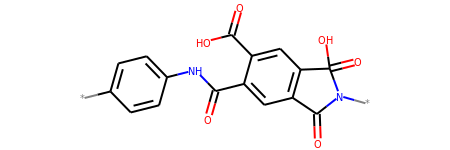

In [140]:
ru.mol_without_atom_index(new_mol)

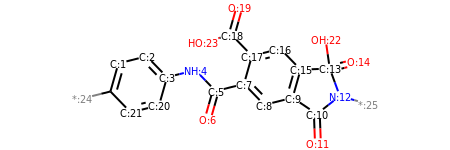

In [141]:
ru.mol_with_atom_index(new_mol)

In [120]:
lps

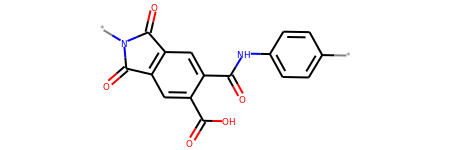

In [116]:
lps[0].mol

In [18]:
importlib.reload(retro)
retro.retrosynthesize([lps[4].SMILES],ro=False,radion=False,ox=False)

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz


[]

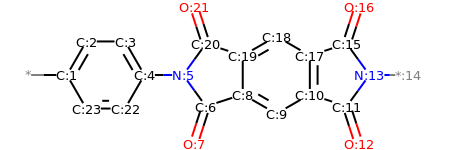

In [149]:
lp.mol

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz


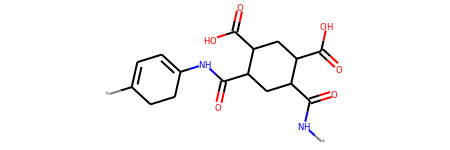

In [159]:
importlib.reload(retro)
retro.ring_close_retro2(lp2)[4].mol

# Do step-growth reaction nh2_xox_edit

In [20]:
mol = intermed.mol #from above

In [21]:
g1,g2 = Chem.MolFromSmarts('[NH2]'),Chem.MolFromSmarts('*O*')

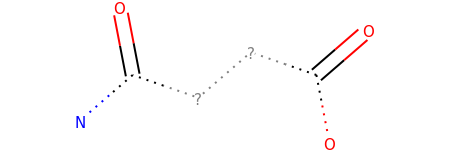

In [22]:
polymer_linkage = Chem.MolFromSmarts('[#6R0](=O)([OH])[C,c][C,c][CR1](=O)[NR1]')
polymer_linkage

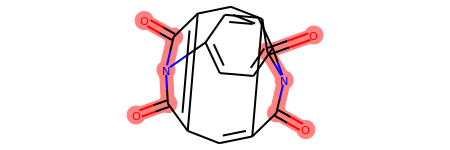

In [23]:
pm.mol

In [24]:
if type(mol) == str:
    mol = Chem.MolFromSmiles(mol)

lp = ru.LinearPol(mol)
pm = lp.PeriodicMol()
pm.GetSSSR()
if pm is None: #periodization failed
    #return None
    print('None1')
try: #sometimes g1 and g2 are given as lists. If so they will fail below.
    if pm.HasSubstructMatch(g1) or pm.HasSubstructMatch(g2): #chain should not have same functional groups we want to react
        if edit_function != nh_nco_edit: #but there are exceptions
            print('None2')
    g1 = [g1] #do this so symmetry check will have an iterable
    g2 = [g2] #do this so symmetry check will have an iterable
except:
    if any([pm.HasSubstructMatch(x) for x in g1] + [pm.HasSubstructMatch(x) for x in g2]): #chain should not have same functional groups we want to react
        if edit_function != nh_nco_edit: #but there are exceptions
            print('None3')      
matches=pm.GetSubstructMatches(polymer_linkage)
match_pairs = list(itertools.combinations(matches, 2))
new_mols = []

In [25]:
match_pair = match_pairs[0]

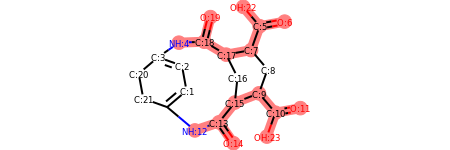

In [26]:
ru.mol_with_atom_index(pm.mol)

In [27]:
match_pair

((5, 6, 22, 7, 17, 18, 19, 4), (10, 11, 23, 9, 15, 13, 14, 12))

In [28]:
'[#6R0](=O)([OH])[C,c][C,c][CR1](=O)[NR1]'

'[#6R0](=O)([OH])[C,c][C,c][CR1](=O)[NR1]'

In [29]:
_,_,a_ioh,a_ic1,a_ic2,a_ico,_,a_in = match_pair[0]
_,_,b_ioh,b_ic1,b_ic2,b_ico,_,b_in = match_pair[1]

In [30]:
bond_type = pm.mol.GetBondBetweenAtoms(a_ic1,a_ic2).GetBondType()
bond_type

rdkit.Chem.rdchem.BondType.SINGLE

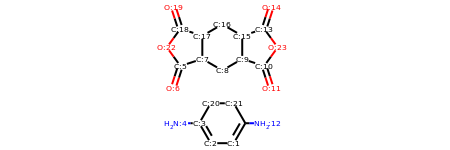

In [33]:
em = Chem.EditableMol(pm.mol)
em.RemoveBond(a_ico,a_in)
em.RemoveBond(b_ico,b_in)

em.AddBond(a_ico,a_ioh,bond_type)
em.AddBond(b_ico,b_ioh,bond_type)

new_mol=em.GetMol()
Chem.SanitizeMol(new_mol)
new_mol

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz


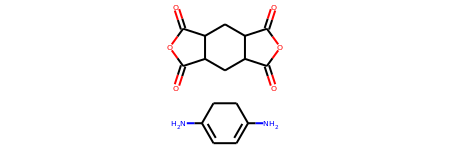

In [38]:
importlib.reload(retro)
retro.sg_depolymerize(mol,polymer_linkage,retro.sg_rxns['[#6R0](=O)([OH])[C,c][C,c][CR1](=O)[NR1]'][0])[0]

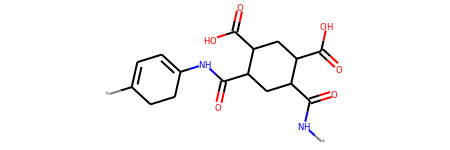

In [42]:
mol

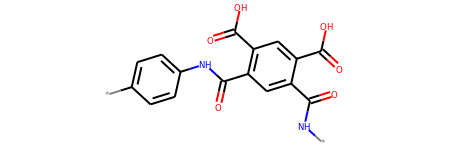

In [41]:
mol2 = Chem.MolFromSmiles('*NC(=O)c2cc(C(=O)Nc1ccc(*)cc1)c(C(=O)O)cc2C(=O)O')
mol2

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz
None5


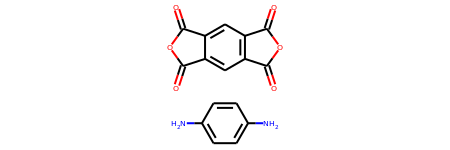

In [45]:
importlib.reload(retro)
retro.sg_depolymerize(mol2,polymer_linkage,retro.sg_rxns['[#6R0](=O)([OH])[C,c][C,c][CR1](=O)[NR1]'][0])[0]

In [39]:
retro.retrosynthesize([lps[4].SMILES],ro=False,radion=False,ox=False)

# Test multi-step retrosynthesis

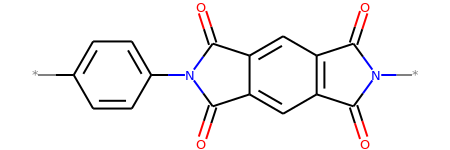

In [8]:
sm = '*c4ccc(n3c(=O)c2cc1c(=O)n(*)c(=O)c1cc2c3=O)cc4'
Chem.MolFromSmiles(sm)

In [89]:
importlib.reload(retro)
out=retro.retrosynthesize2([sm])

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz
!!!Periodization Failed!!!
!!!Periodization Failed!!!
RDKit ERROR: Failed Expression: df_init
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [18:28:50] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: RingInfo not initialized
RDKit ERROR: Violation occurred on line 37 in file /home/conda/feedstock_root/build_artifacts/rdkit_1540561308834/work/Code/GraphMol/RingInfo.cpp
RDKit ERROR: Failed Expression: df_init
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [18:28:50] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: RingInfo not initialized
RDKit ERROR: Violation occurred on line 37 in file /home/conda/feedstock_root/build_artifacts/rdkit_1540561308834/work/Code/GraphMol/RingInfo.cpp
RDKit ERROR: Failed Expression: df_init
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [18:28:50] 
RDKit ERROR: 
RDKit ER

In [90]:
out

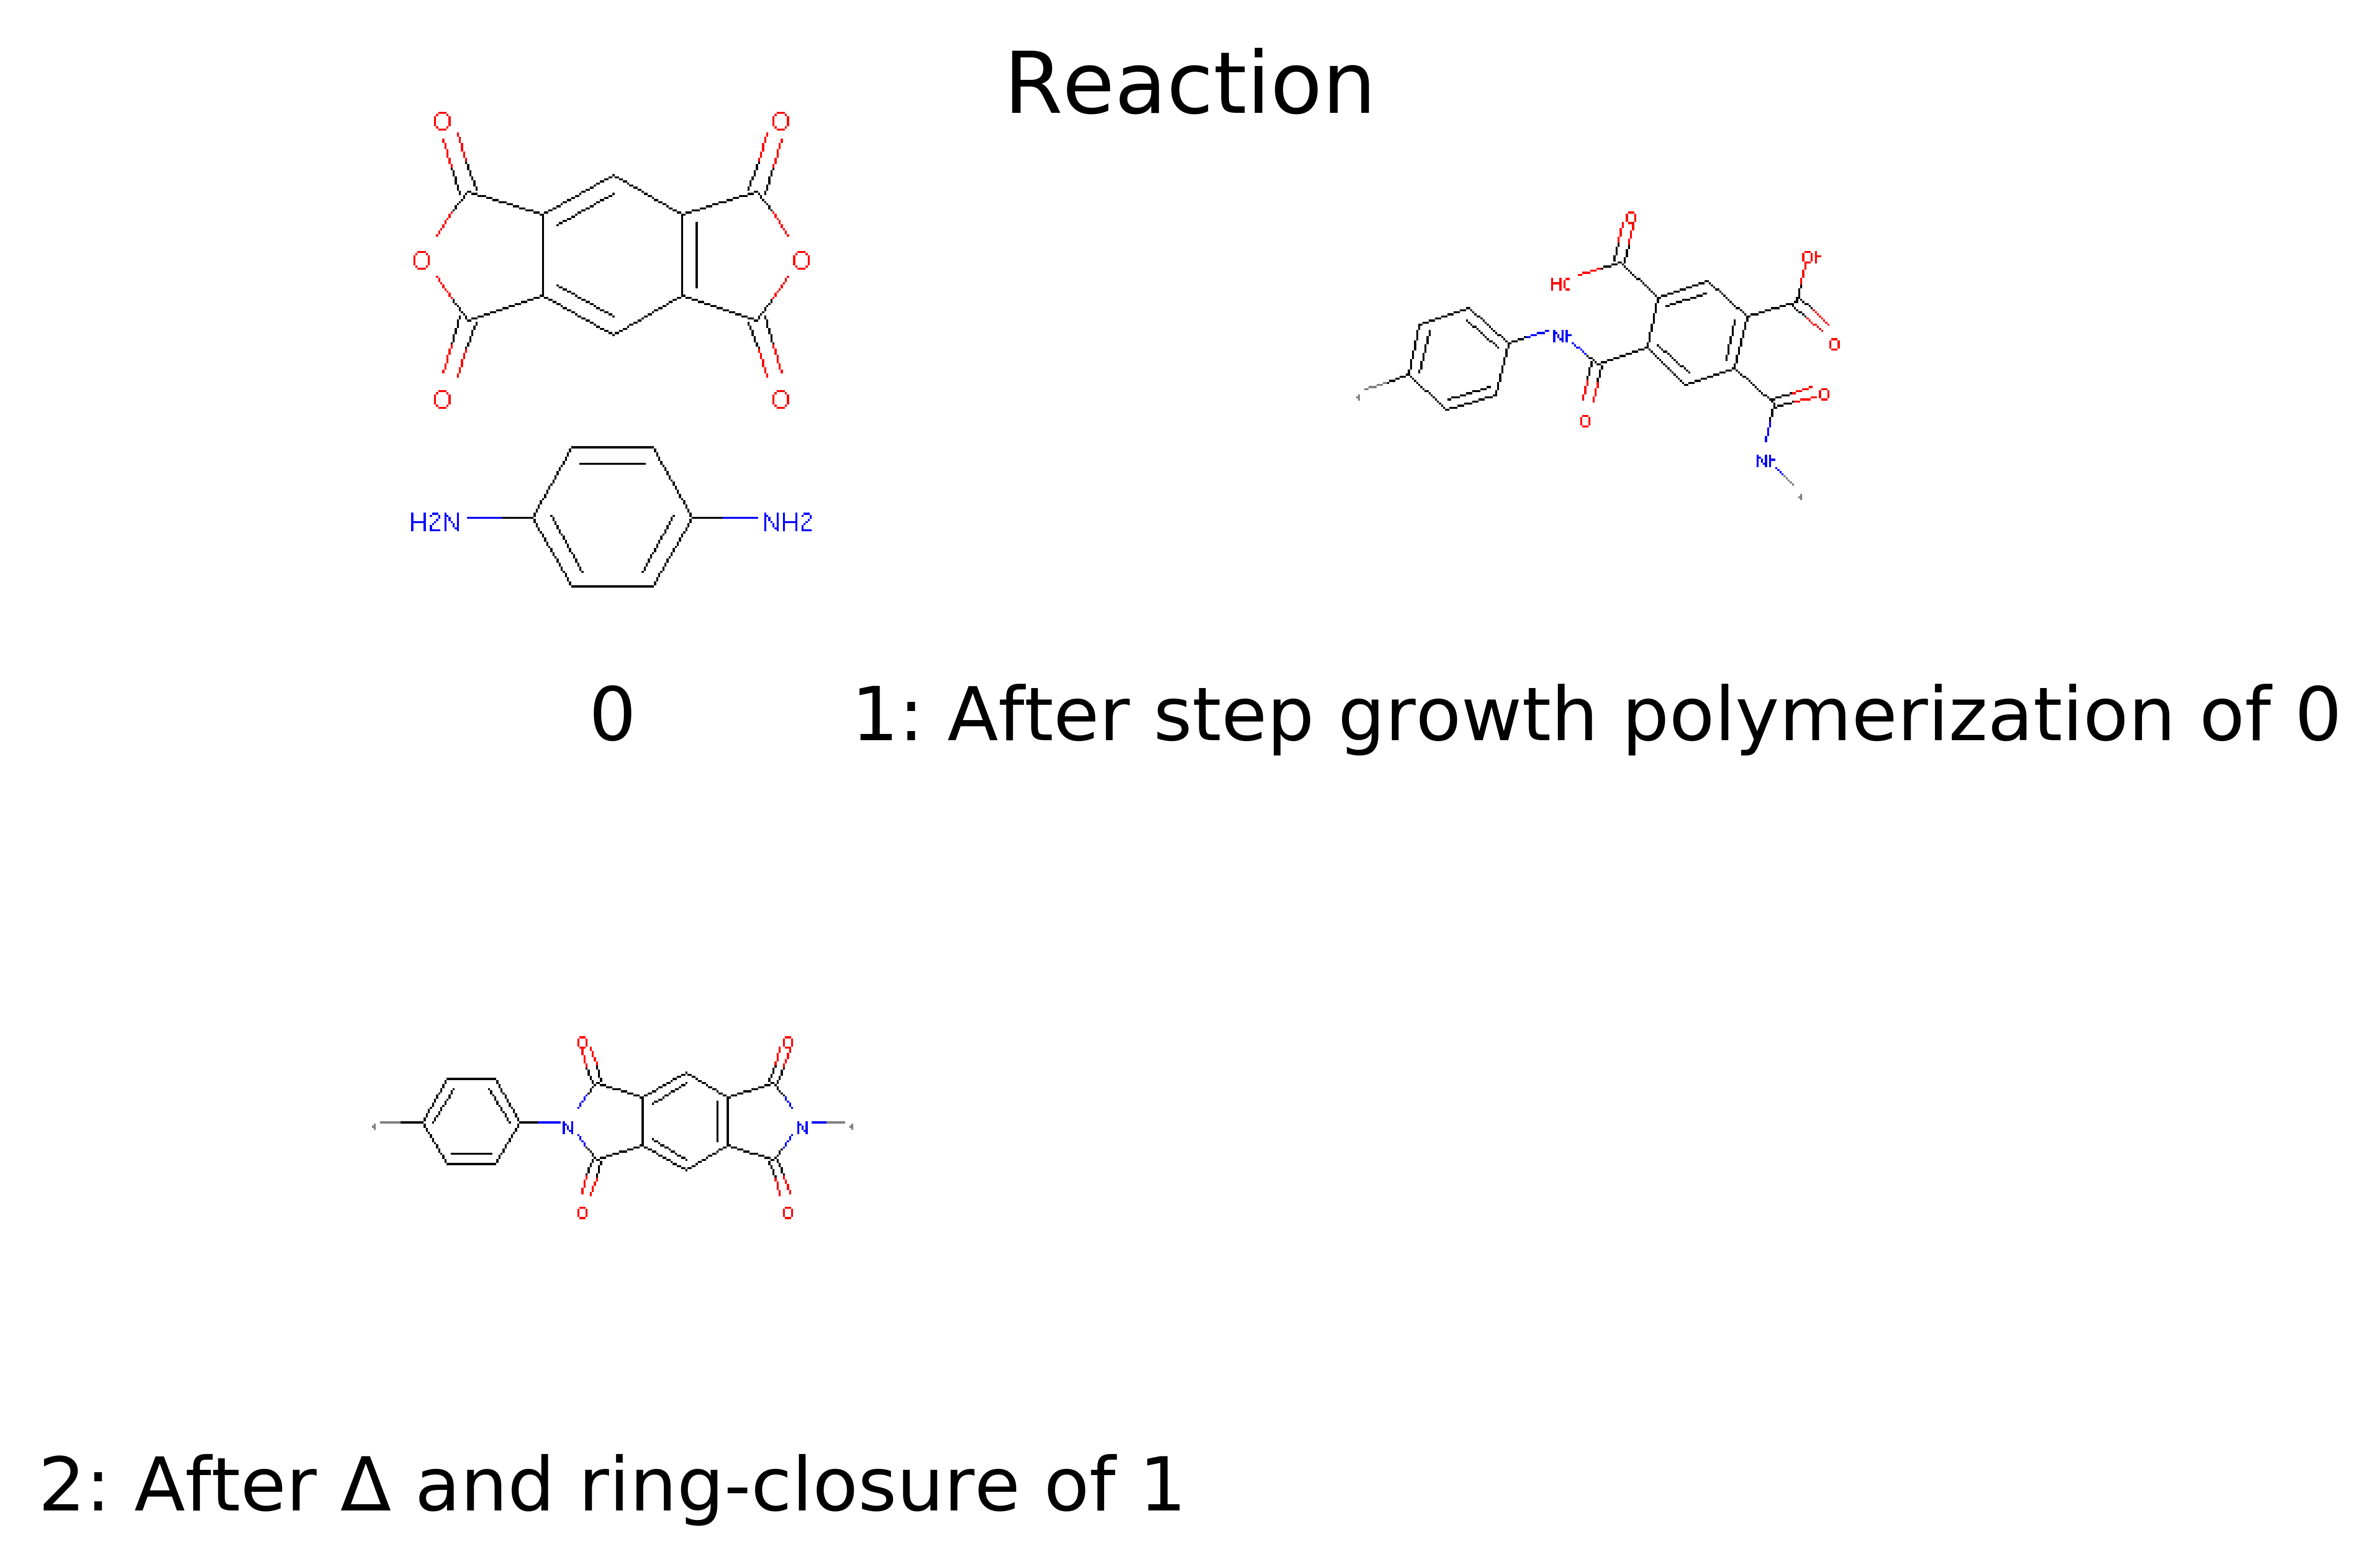

In [93]:
mpl.rcParams['figure.dpi']= 800
out[0].DrawSteps()

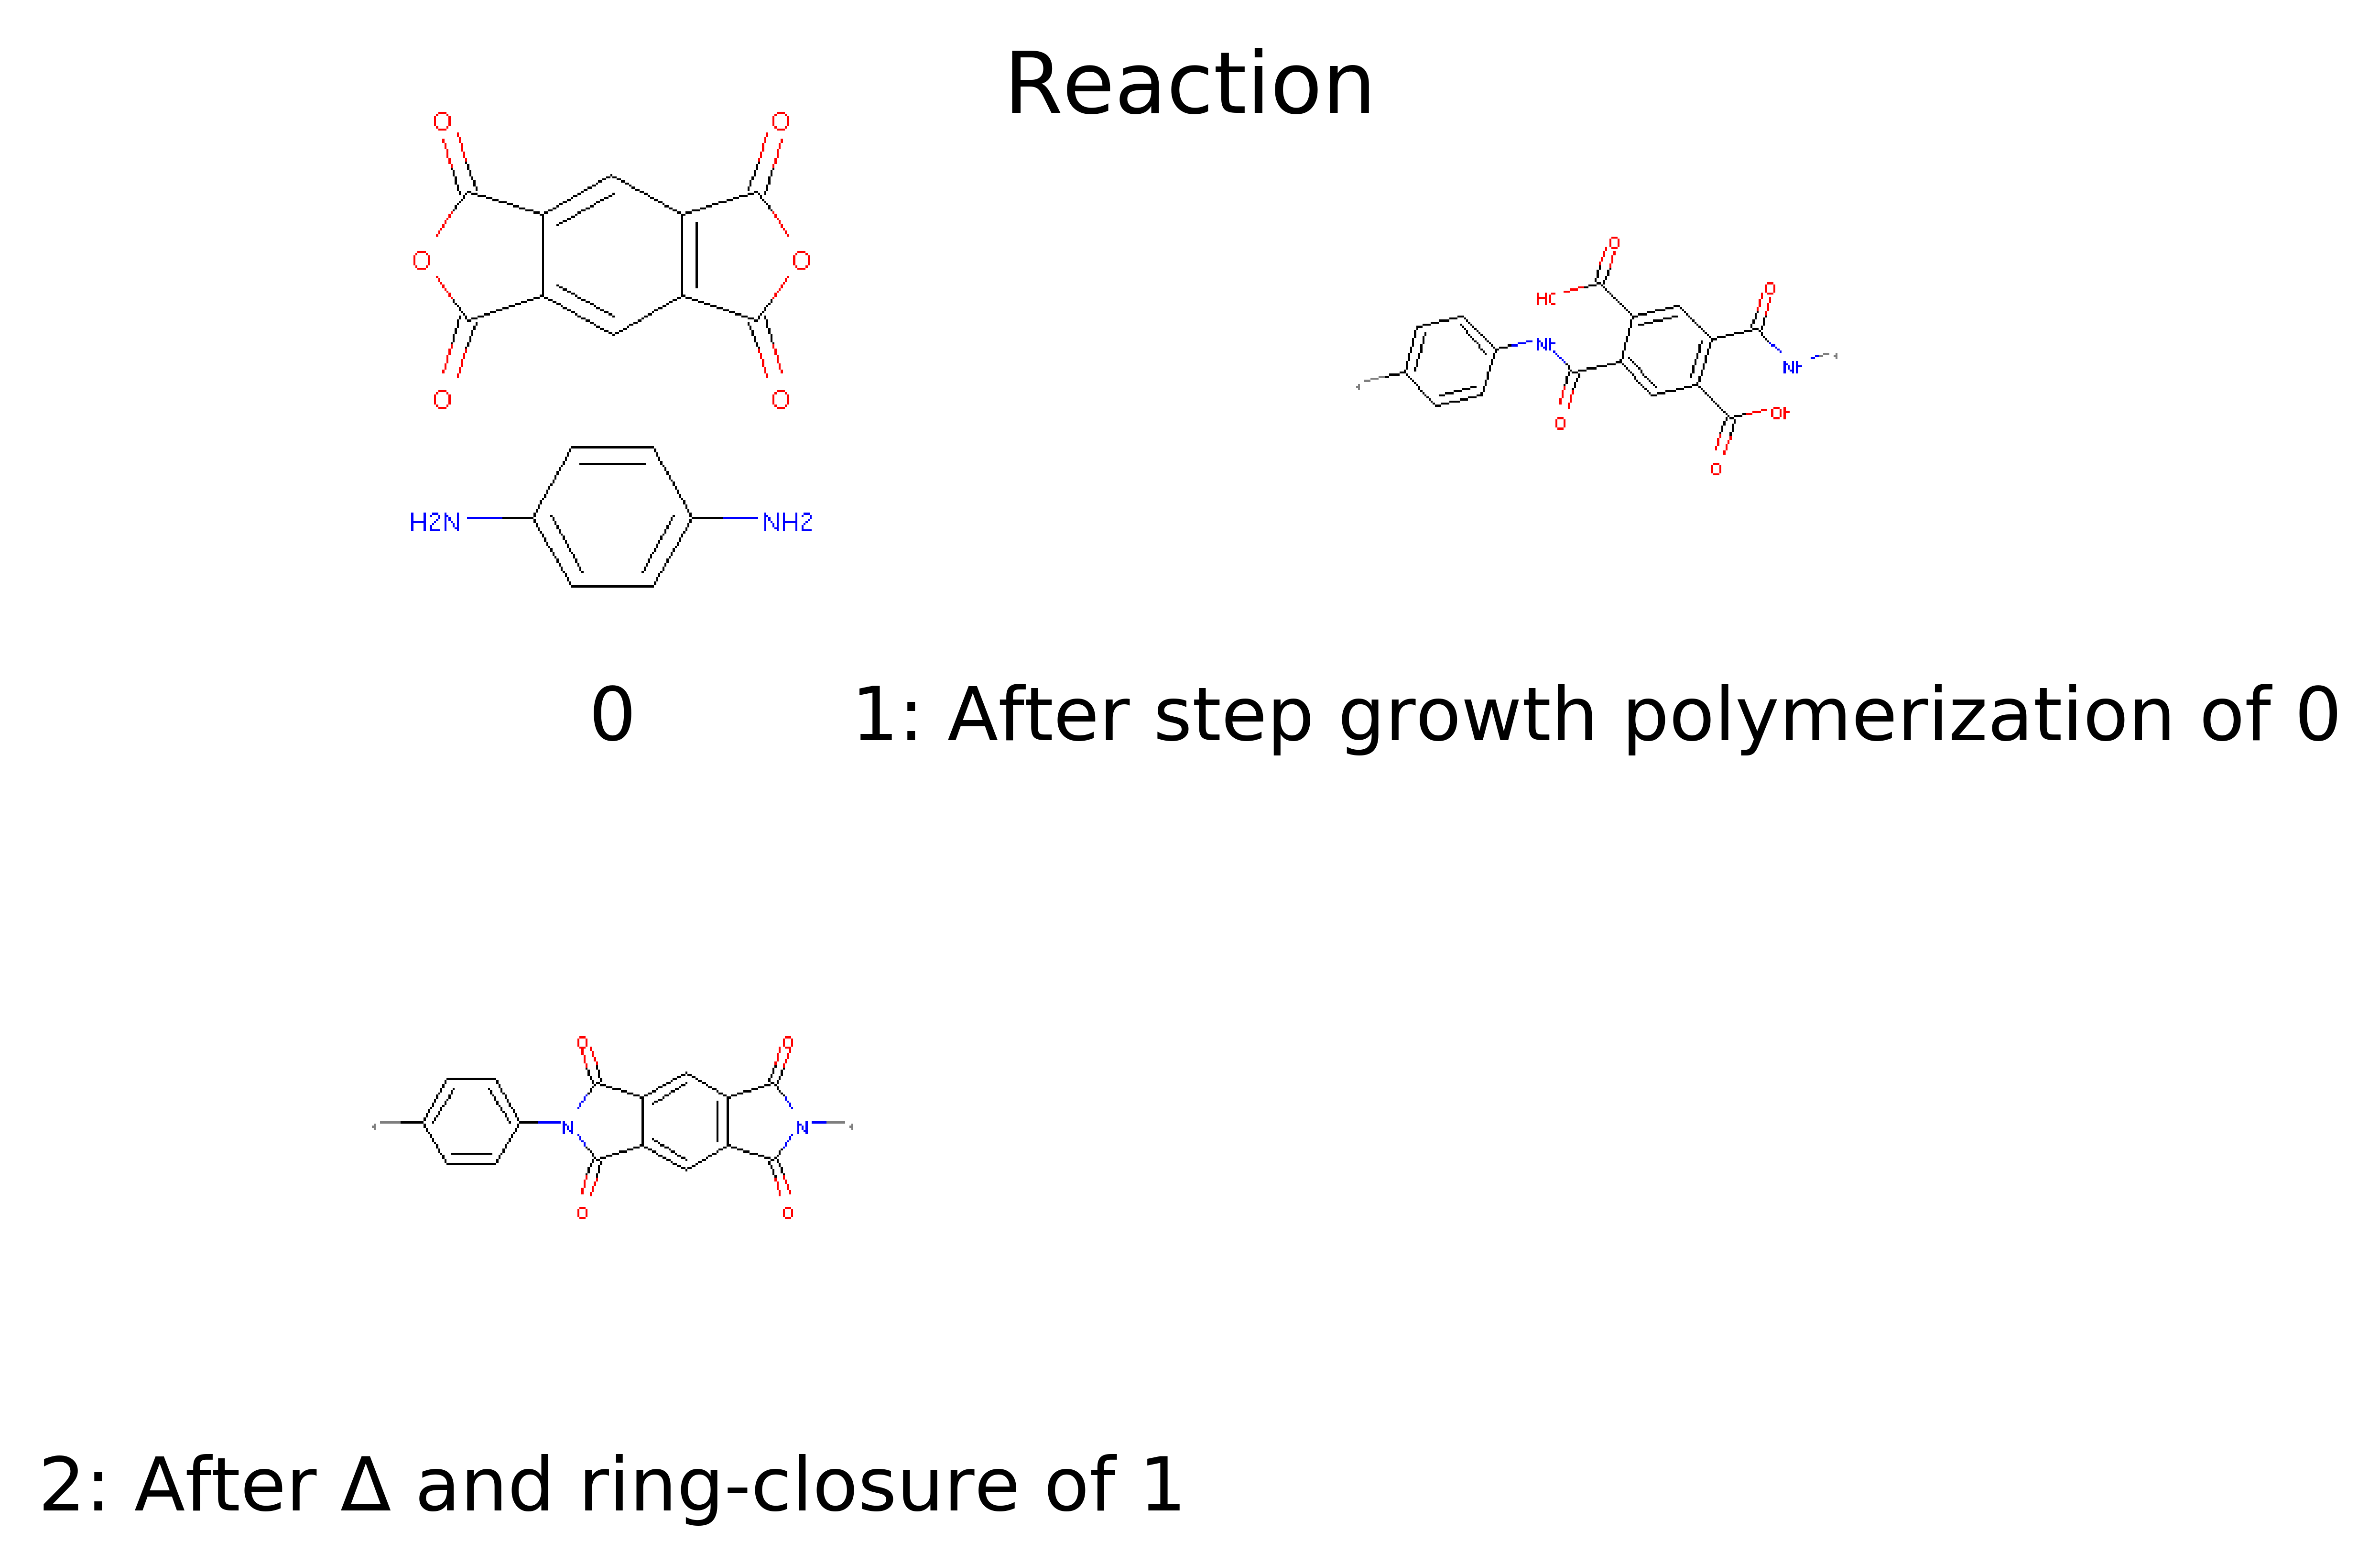

In [94]:
mpl.rcParams['figure.dpi']= 800
out[1].DrawSteps()

In [97]:
Chem.MolToSmiles(out[0].r_mols[-1])

'*NC(=O)c1cc(C(=O)Nc2ccc(*)cc2)c(C(=O)O)cc1C(=O)O'

In [98]:
Chem.MolToSmiles(out[1].r_mols[-1])

'*NC(=O)c1cc(C(=O)O)c(C(=O)Nc2ccc(*)cc2)cc1C(=O)O'

In [66]:
list(reversed([1,2,3]))

[3, 2, 1]

In [35]:
importlib.reload(retro)
retro.retro_depolymerize(out[2].reaction_step_ls[-1].reactant_mol,sg=True,radion=False,ox=False,ro=False,debug=True)[0]

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz
None2
None2
None2
None4
None4
None4
None3
None3
None2
None5


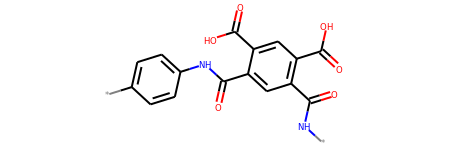

In [33]:
out[2].reaction_step_ls[-1].reactant_mol